## Multi-Mode Resource-Constrained Project Scheduling

This notebook demonstrates how to model and solve the classical Multi-Mode Resource-Constrained Project Scheduling Problem using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API. The MMRCPSP is a generalization of the Resource-Constrained Project Scheduling problem, see [`rcpsp.ipynb`](https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb).

### Problem Definition

In the MMRCPSP, we consider a finite set of tasks indexed by $i \in [1..N]$, where each task $i$ has a mode set $M[i]$ and exactly one mode $j \in M[i]$ must be chosen. The project uses two resource classes: renewable resources indexed by $k \in [1..R]$ with capacities $\mathrm{CR}_k>0$, and nonrenewable resources indexed by $k \in [1..S]$ with capacities $\mathrm{CS}_k>0$. For every task–mode pair $(i,j)$ with $j \in M[i]$, the duration is $PT_{ij}>0$, the renewable demand on resource $k$ is $\mathrm{QR}_{ijk}\ge 0$ (consumed only while the task in mode $j$ is executing), and the nonrenewable usage on resource $k$ is $\mathrm{QS}_{ijk}\ge 0$. A set of precedence relations $P \subseteq [1..N]\times[1..N]$ specifies the required order of tasks. A feasible schedule assigns a mode to every task and start times such that: (i) all precedences in $P$ are respected; (ii) at every time point, the sum of renewable demands of all currently executing chosen modes does not exceed $\mathrm{CR}_k$ for each renewable $k$; and (iii) the total nonrenewable consumption $\sum_{i}\sum_{j \in M[i]} \delta_{ij}\,\mathrm{QS}_{ijk}$ does not exceed $\mathrm{CS}_k$ for each nonrenewable $k$, where $\delta_{ij}\in\{0,1\}$ indicates whether mode $j$ is chosen for task $i$. The objective is to minimize the makespan $C_{\max}$, i.e., the completion time of the last finishing task, over all feasible assignments of modes and start times.


### CPLEX Formulation

$$
\begin{aligned}
\min \quad 
& \max_{i \in [1..N]} \mathrm{endOf}(x_i) 
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \mathrm{alternative}\!\left(x_i,\; [\,y_{ij}\,]_{j\in M[i]}\right), 
\qquad & \forall i\in[1..N] 
\quad & \text{(2)} \\[1mm]
& \sum_{i\in[1..N]}\sum_{j\in M[i]} 
  \mathrm{pulse}\!\left(y_{ij},\, \mathrm{QR}_{ijk}\right)
  \le \mathrm{CR}_k, 
\qquad & \forall k\in[1..R] 
\quad & \text{(3)} \\[1mm]
& \sum_{i\in[1..N]}\sum_{j\in M[i]} 
  \mathrm{presenceOf}(y_{ij})\cdot \mathrm{QS}_{ijk}
  \le \mathrm{CS}_k, 
\qquad & \forall k\in[1..S] 
\quad & \text{(4)} \\[1mm]
& \mathrm{endBeforeStart}(x_i, x_j), 
\qquad & \forall (i,j)\in P 
\quad & \text{(5)} \\[1mm]
& \text{interval } x_i, 
\qquad & \forall i\in[1..N] 
\quad & \text{(6)} \\[1mm]
& \text{interval } y_{ij}\ \text{optional, size}=PT_{ij}, 
\qquad & \forall i\in[1..N],\ \forall j\in M[i] 
\quad & \text{(7)}
\end{aligned}
$$


Objective:
- **(1)** Minimize the **makespan**  $C_{\max} = \max_{i\in[1..N]} \mathrm{endOf}(x_i)$
  — i.e., finish all tasks as early as possible while satisfying constraints.

Modeling constraints:
- **(2)** Ensures one mode $y_{ij}$ is selected for task $i$ and its timing matches $x_i$.
- **(3)** Enforces **renewable resource limits** so that, at any time, $\sum_{i,j}\mathrm{pulse}(y_{ij}, \mathrm{QR}_{ijk}) \le \mathrm{CR}_k$.
- **(4)** Enforces **nonrenewable resource limits** at the project level, $\sum_{i,j}\mathrm{presenceOf}(y_{ij}) \cdot \mathrm{QS}_{ijk} \le \mathrm{CS}_k$.
- **(5)** Maintains all **precedence relations** $(i,j)\in P$.

Variables:
- **(6)** $x_i$: a **mandatory interval** representing the execution of task $i$.  
- **(7)** $y_{ij}$: **optional intervals**, each representing task $i$ performed in **mode $j$** with fixed duration $PT_{ij}$. Each task $x_i$ must coincide with **exactly one** of its modes $y_{ij}$.


#### Note on the [`alternative()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) and the [`presenceOf()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) functions

- **$\mathrm{alternative}(x_i,\,[y_{ij}])$** — links a **mandatory interval** $x_i$ with a set of **optional intervals** $y_{ij}$. Exactly one $y_{ij}$ must be **present**, and when it is, its **start**, **end**, and **duration** define those of $x_i$. Typically used to model **exclusive mode or machine choices** for a single task.

- **$\mathrm{presenceOf}(y_{ij})$** — returns $1$ if the optional interval $y_{ij}$ **is present** in the solution (that mode is chosen), and $0$ otherwise. It allows expressing **logical or resource constraints** depending on whether an operation or mode is active.


#### Symbols and Notation

| Symbol / Function | Meaning | docplex.cp reference |
|---|---|---|
| $N$ | Number of tasks | — |
| $M[i]$ | Mode set of task $i$ | — |
| $R, S$ | Number of renewable / nonrenewable resources | — |
| $PT_{ij}$ | Duration of task $i$ in mode $j$ | — |
| $\mathrm{QR}_{ijk}$ | Renewable demand of task $i$ in mode $j$ on resource $k$ | — |
| $\mathrm{QS}_{ijk}$ | Nonrenewable use of task $i$ in mode $j$ on resource $k$ | — |
| $\mathrm{CR}_k, \mathrm{CS}_k$ | Capacities of renewable / nonrenewable resource $k$ | — |
| $x_i$ | **Mandatory** interval variable for task $i$ | [docplex.cp.modeler.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) |
| $y_{ij}$ | **Optional** interval for mode $j$ of task $i$ | [docplex.cp.modeler.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) |
| $\mathrm{alternative}(x_i,\,[y_{ij}])$ | Selects **exactly one** mode $y_{ij}$ and synchronizes it with $x_i$ | [docplex.cp.modeler.alternative](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) |
| $\mathrm{pulse}(y_{ij},\, \mathrm{QR}_{ijk})$ | Time-varying usage of renewable resource $k$ while $y_{ij}$ executes | [docplex.cp.modeler.pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) |
| $\mathrm{presenceOf}(y_{ij})$ | 1 if the optional interval is present, else 0 | [docplex.cp.modeler.presence_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) |
| $\mathrm{endBeforeStart}(x_i, x_j)$ | Enforce $x_j$ to start after $x_i$ ends | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) |
| $\max_i\, \mathrm{endOf}(x_i)$ | Makespan of the project | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $\min C_{\max}$ | Objective: minimize makespan | [docplex.cp.modeler.minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) |


### CPLEX Implementation

> This notebook is an adaptation of the *MMRCPSP* example from the [IBM Decision Optimization CPLEX Modeling for Python (DOcplex) Examples Repository](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master).  

#### Imports

In [1]:
from docplex.cp.model import *

# Needed only for visualisation
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt

#### Reading the data file

In [2]:
# Read next non empty line
def next_int_line(f):
    line = None
    while not line:
       line = f.readline().split()
    return [int(v) for v in line]

In [3]:
filename = "../data/rcpspmm/rcpspmm_default.data"

# Available files are rcpspmm_default, and different rcpspmm_XXXXXX.
# First line contains the number of tasks, the number of renewable and non-renewable resources.
# Second line contains the capacities of the renewable resources.
# Third line contains the capacities of the non_renewable resources.
# The next N lines are description of tasks, with:
# - the id of the task,
# - the number of modes for this task,
# - the number of successors followed by the list of successor numbers
# The rest of the file consists of one line per task mode, containing:
# - the id of the task (from zero)
# - the id of the mode (from 1)
# - the duration of the task in this mode
# - the demand for renewable resources
# - the demand for non-renewable resources

with open(filename, "r") as f:
    N, R, S = next_int_line(f) # N tasks, R renewables, S nonrenewables
    CR = next_int_line(f) # renewable capacities CR_k
    CS = next_int_line(f) # nonrenewable capacities CS_k

    # N task header lines: <task_id> <#modes> <#succ> <succ_1> ... <succ_ns>
    TASKS = [next_int_line(f) for _ in range(N)]

    # Number of mode lines to read = sum of #modes over tasks
    nb_mode_lines = sum(t[1] for t in TASKS)

    # Mode lines: <task_id> <mode_id> <duration> <R-demands[1..R]> <S-demands[1..S]>
    TASK_MODES = [next_int_line(f) for _ in range(nb_mode_lines)]

#### Prepare structures & notation mapping

In [4]:
# Convenience notations
M = {t[0]: list(range(1, t[1] + 1)) for t in TASKS} # M[i]
P = {(t[0], s) for t in TASKS for s in t[3:3+t[2]]} # Precedence 
PT = { (m[0], m[1]): m[2] for m in TASK_MODES } # durations
QR = { (m[0], m[1]): m[3:3+R] for m in TASK_MODES } # renewable demands
QS = { (m[0], m[1]): m[3+R:3+R+S] for m in TASK_MODES } # nonrenewable demands


#### Create model and variables

In [5]:
# Create a CP Optimizer model
mdl = CpoModel()

# (6) x_i: mandatory intervals
x = { i: interval_var(name=f"x_{i}") for i in range(N) }  

# (7) y_ij: optional intervals per mode with fixed size PT_ij
y = { (i,j): interval_var(name=f"y_{i}_{j}", optional=True, size=PT[(i,j)])
      for i in range(N) for j in M[i] }     


#### Add constraints and objective

In [ ]:
# (1) objective: minimize makespan max_i endOf(x_i)
mdl.add(minimize(max(end_of(x[i]) for i in range(N))))

# (2) mode selection: alternative(x_i, {y_ij | j∈M[i]})
mdl.add(alternative(x[i], [y[(i,j)] for j in M[i]]) for i in range(N))

# (3) renewable capacity: sum pulse(y_ij, QR_ijk) ≤ CR_k
mdl.add([sum(pulse(y[(i,j)], QR[(i,j)][k]) for (i,j) in PT if QR[(i,j)][k] > 0) <= CR[k] for k in range(R)])

# (4) nonrenewable capacity: sum presenceOf(y_ij)*QS_ijk ≤ CS_k
mdl.add([sum(presence_of(y[(i,j)]) * QS[(i,j)][k] for (i,j) in PT if QS[(i,j)][k] > 0) <= CS[k] for k in range(S)])

# (5) precedences: enforce endBeforeStart on arcs P
mdl.add([end_before_start(x[i], x[j]) for (i, j) in P])

#### Solve the model

In [7]:
print('Solving model...')
res = mdl.solve(FailLimit=100000,TimeLimit=10)
print('Solution: ')
res.print_solution()

Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.2.0 --
 ! Minimization problem - 136 variables, 94 constraints
 ! FailLimit            = 100000
 ! TimeLimit            = 10
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 306.8 (before), 306.8 (after)
 !  . Memory usage      : 968.3 kB (before), 968.3 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        136                 -
 + New bound is 38
 ! Using iterative diving.


 *            72       74  0.12s        1      (gap is 47.22%)
 *            71      239  0.12s        1      (gap is 46.48%)
 *            70      478  0.12s        1      (gap is 45.71%)
 *            62      551  0.12s        1      (gap is 38.71%)
 *            61      724  0.12s        1      (gap is 37.70%)
 *            60      748  0.12s        1      (gap is 36.67%)
 *            59      918  0.12s        1      (gap is 35.59%)
              59     1000          2    1   F          presenceOf(y_32_1)
 *            54     1348  0.12s        1      (gap is 29.63%)
 *            53     1764  0.12s        1      (gap is 28.30%)
              53     2000          2    1        29 != startOf(y_17_1)
              53      983          2    2   F        -
 + New bound is 39 (gap is 26.42%)
              53     1000          2    2             !presenceOf(y_14_3)
 *            50     1173  0.12s        2      (gap is 22.00%)
 *            49     1364  0.12s        2      (gap is 20.41%

#### Visualisation

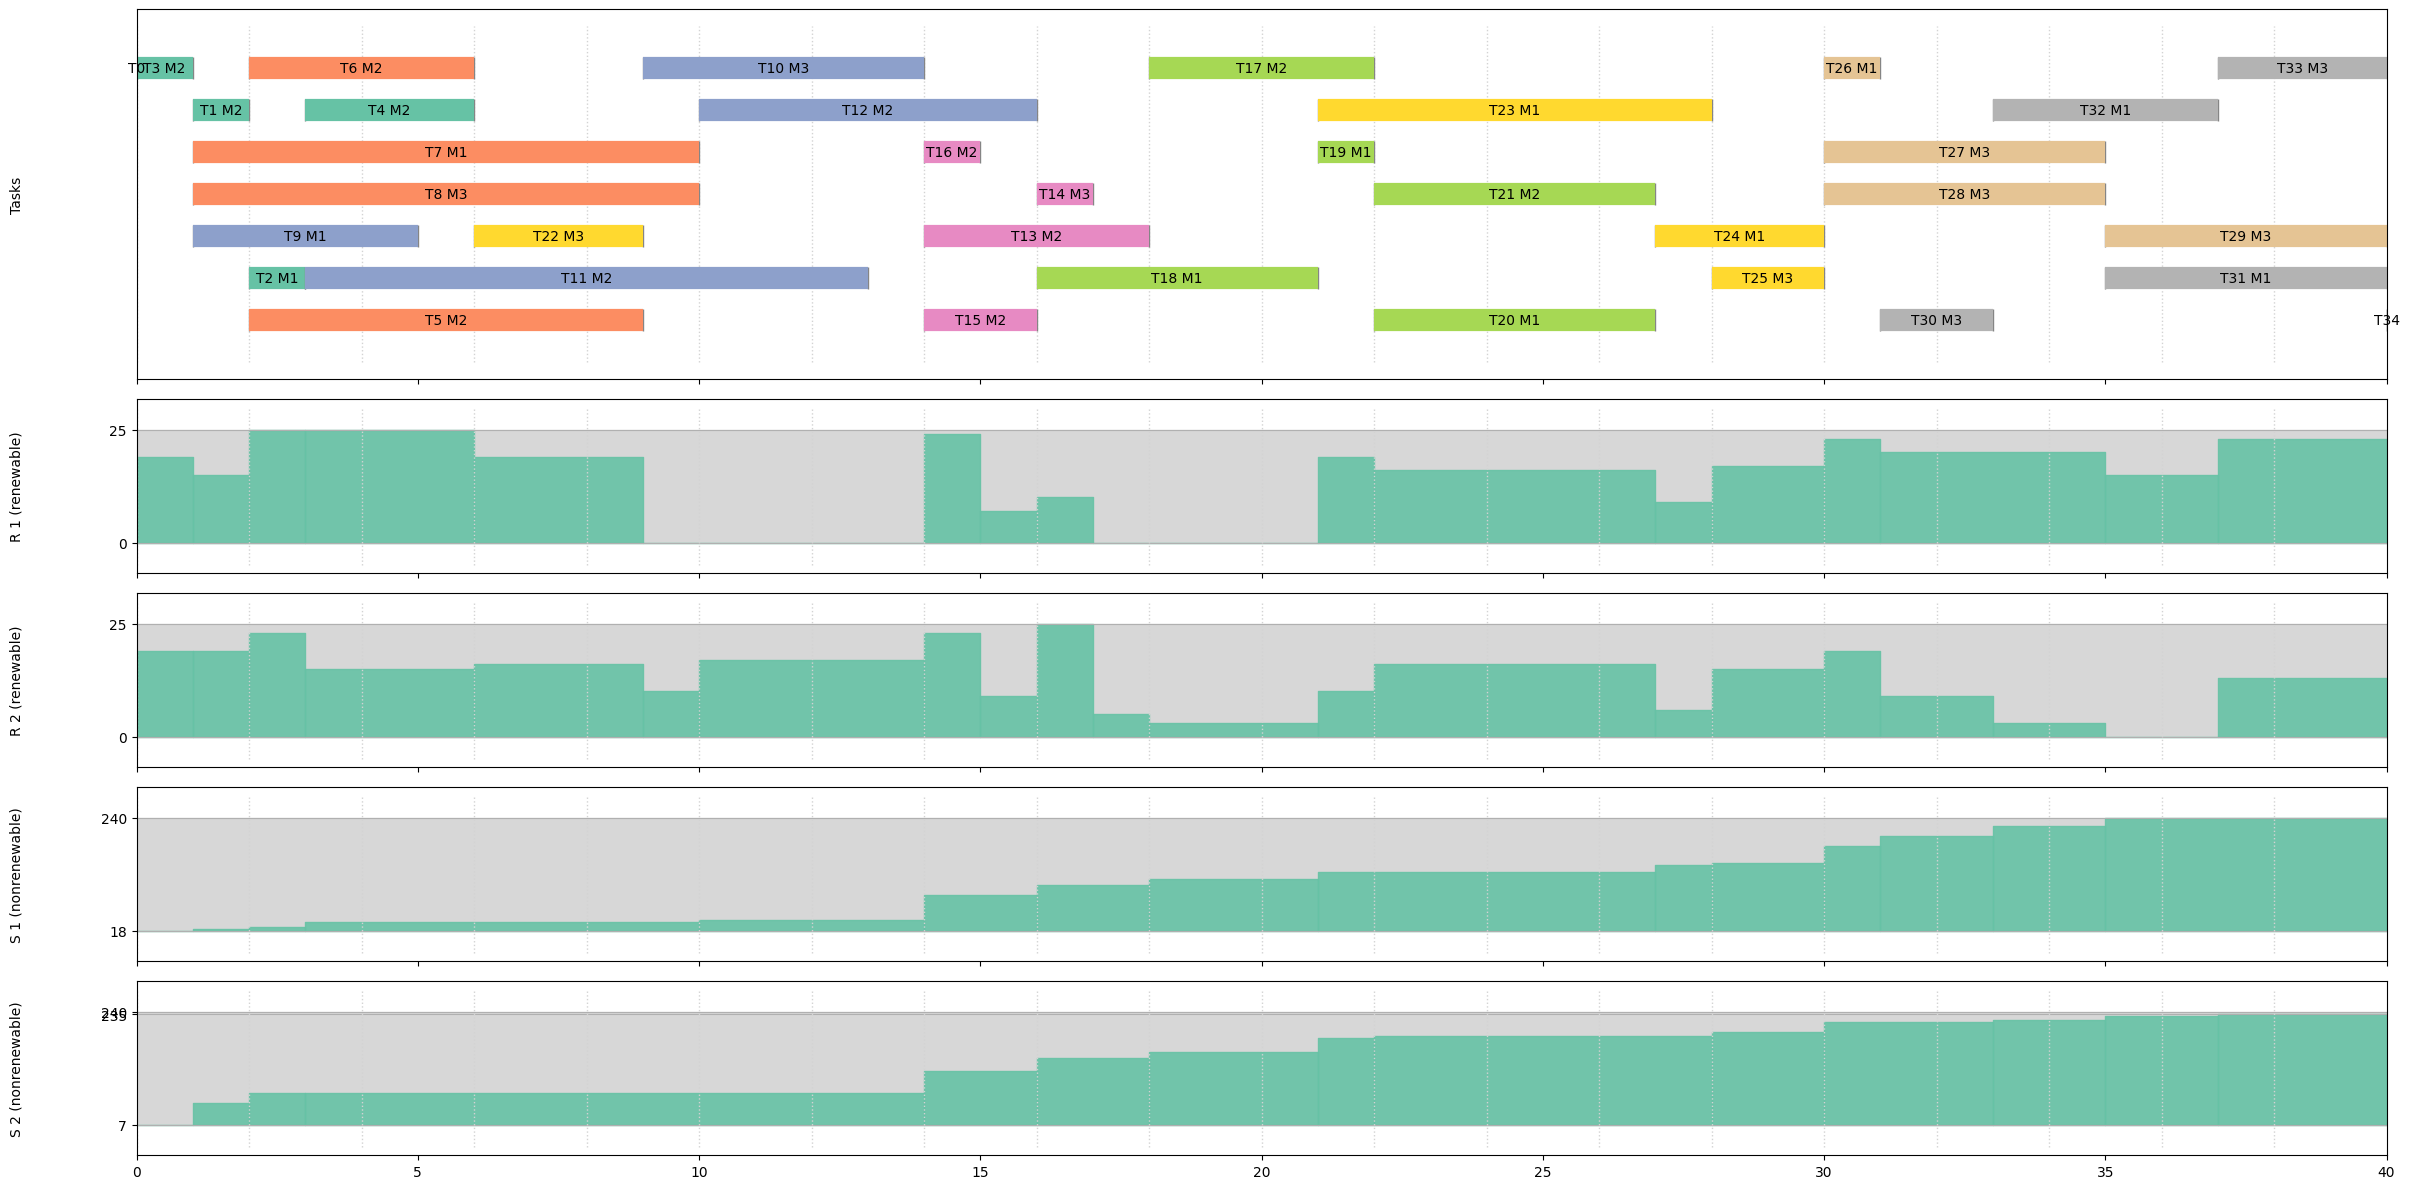

In [8]:
if res and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (24, 12)
    load_R = [CpoStepFunction() for k in range(R)]
    load_S = [CpoStepFunction() for k in range(S)]

    for (i, j), yij in y.items():
        itv = res.get_var_solution(yij)
        if itv.is_present():
            s, e = itv.get_start(), itv.get_end()
            # renewable: add pulse over [s, e)
            for k in range(R):
                q = QR[(i, j)][k]
                if q > 0:
                    load_R[k].add_value(s, e, q)
            # nonrenewable: add cumulative step at start time (persist to the end of horizon)
            for k in range(S):
                q = QS[(i, j)][k]
                if q > 0:
                    load_S[k].add_value(s, INTERVAL_MAX, q)
    visu.panel('Tasks')
    for i in range(N):
        xi = res.get_var_solution(x[i])
        chosen = next((j for j in M[i] if res.get_var_solution(y[(i, j)]).is_present()), None)
        label = f"T{i} M{chosen}" if chosen is not None and i != 0 and i != N-1 else f"T{i}"
        visu.interval(xi, i, label)
    for k in range(R):
        visu.panel(f"R {k+1} (renewable)")
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, CR[k])], style='area', color='lightgrey')
        visu.function(segments=load_R[k], style='area', color=k)
    for k in range(S):
        visu.panel(f"S {k+1} (nonrenewable)")
        # Capacity as a flat band; cumulative consumption as a rising step function
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, CS[k])], style='area', color='lightgrey')
        visu.function(segments=load_S[k], style='area', color=k)
    visu.show()

### Additional Resources

- **RCPSP**
    - https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb